In [106]:
# Base Data Science snippet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm_notebook

%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from comet_ml import Experiment

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
import sys
sys.path.append("../")

from beth import Game,RandomPlayer,HumanPlayer
from beth.move import Move
from beth.board import Board
from beth.ai import TreeSearchAI,StockfishAI
from beth.tree import TreeSearch

# Playground

In [407]:
stockfish_path = "C:/Users/talvesdacosta/Downloads/stockfish_13_win_x64/stockfish_13_win_x64/stockfish_13_win_x64.exe"

In [64]:
# AIs
black = TreeSearchAI(depth = 5,breadth = 10,max_time = 5)
# black = TreeSearchAI(depth = 3,wait = 0.5,breadth = 10)
# # black = StockfishAI(stockfish_path,elo=1350)
# white = StockfishAI(stockfish_path,level=1,limit = 0.01)
# black = StockfishAI(stockfish_path,level=1,limit = 0.01)


# # Humans
white = HumanPlayer()
# black = HumanPlayer()

# Init and run the game
game = Game(white,black)
game.move(x)

[4.0,
 -5.0,
 2.0,
 -5.0,
 5.0,
 -4.0,
 4.0,
 -4.0,
 -1.5,
 -3.5,
 5.5,
 -2.0,
 1.5,
 -2.0,
 1.5,
 -1.0,
 6.0,
 -5.5,
 3.0,
 -3.0,
 1.0,
 -6.0,
 7.0,
 0.0,
 3.0,
 -2.0,
 5.0,
 -1.0]

# Playground ML

In [3]:
moves = """1.e4 e5 2.Nf3 Nc6 3.Bb5 a6 4.Ba4 Nf6 5.O-O Be7 6.Re1 b5 7.Bb3
d6 8.c3 O-O 9.h3 Nb8 10.d4 Nbd7 11.Nbd2 Bb7 12.Bc2 Re8 13.Nf1
Bf8 14.Ng3 g6 15.Bg5 h6 16.Bd2 exd4 17.cxd4 c5 18.d5 Nb6 19.Ba5
Nfd7 20.b3 Bg7 21.Rc1 Qf6 22.Rb1 b4 23.Ne2 Qe7 24.a3 bxa3 25.Bc3
f5 26.Bxg7 Qxg7 27.Nf4 fxe4 28.Nh4 g5 29.Ne6 Qf6 30.Qg4 Nxd5
31.Nxg5 hxg5 32.Qxd7 Nb4 33.Qxb7 Nxc2 34.Rxe4 a2 35.Rf1 Nb4 36.Rg4
a1Q 37.Rxa1 Qxa1+ 38.Kh2 Qg7 39.Qf3 Qe5+ 40.g3 Rf8 41.Qg2 Qf6
42.f4 Ra7 43.Rxg5+ Rg7 44.Rh5 Qe6 45.g4 Rxf4"""

In [4]:
import re

def pgn_moves_to_moves(x):
    return re.sub("\d+[.]", '', x).strip()

In [105]:
import chess.pgn
from beth.board import Board

In [6]:
def parse_pgn_game_to_tensors(game):
    
    boards = []
    moves = []
    board = game.board()
    
    for move in game.mainline_moves():
        array = Board(board.board_fen()).to_array()
        boards.append(array)
        moves.append((move.from_square,move.to_square))
        board.push(move)
        
    return boards,moves

def one_hot_moves(moves):
    moves = np.array(moves)
    moves_one_hot = np.zeros((*moves.shape,64))
    moves_one_hot[np.arange(len(moves)),0,moves[:,0]] = 1
    moves_one_hot[np.arange(len(moves)),1,moves[:,1]] = 1
    return moves_one_hot

def parse_pgn_games_for_ml(pgn_path,n = 100):
    boards = []
    moves = []
    i = 0
    
    pgn = open(pgn_path)
    
    while True:
        try:
            game = chess.pgn.read_game(pgn)
            boards_game,moves_game = parse_pgn_game_to_tensors(game)
            boards.extend(boards_game)
            moves.extend(moves_game)

            i += 1

            if i == n:
                break
        except:
            break
            
    boards = np.stack(boards)
    moves = one_hot_moves(moves)
    return boards,moves

In [108]:
boards,moves = parse_pgn_games_for_ml("../data/raw/lichess/lichess_db_standard_rated_2013-01.pgn",n = 500)

In [128]:
np.save("../data/processed/lichess/boards_lichess1.npy",boards)

In [129]:
np.save("../data/processed/lichess/moves_lichess1.npy",moves)

## Desining the architecture

In [127]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D,Concatenate
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

In [169]:
class SimpleSupervisedLearningModel(Model):
  def __init__(self):
    super().__init__()
    self.conv1 = Conv2D(10, 3, activation='relu',padding = "same")
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(64,activation = "sigmoid")
    self.d3 = Dense(64,activation = "sigmoid")

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    from_square = self.d2(x)
    to_square = self.d3(x)
    
    pred = tf.concat([
        from_square[:,tf.newaxis,:],
        to_square[:,tf.newaxis,:],
    ],axis = 1)
    
    return pred

loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

def loss_fn(y_true,y_pred):
    # training=training is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    
    from_loss = loss_object(y_true[:,0,:],y_pred[:,0,:])
    to_loss = loss_object(y_true[:,1,:],y_pred[:,1,:])
    
    return from_loss + to_loss

optimizer = Adam(learning_rate=0.001)


model = SimpleSupervisedLearningModel()
model.compile(loss=loss_fn, optimizer=optimizer,metrics = ["accuracy"])

In [170]:
model.fit(boards,moves,batch_size = 32,epochs = 50,validation_split = 0.1)

Epoch 1/50
849/849 [==============================] - 7s 7ms/step - loss: 8.0561 - accuracy: 0.0409 - val_loss: 7.7230 - val_accuracy: 0.0733
Epoch 2/50
849/849 [==============================] - 5s 6ms/step - loss: 7.6494 - accuracy: 0.0800 - val_loss: 7.5726 - val_accuracy: 0.0857
Epoch 3/50
849/849 [==============================] - 5s 6ms/step - loss: 7.4970 - accuracy: 0.0888 - val_loss: 7.5292 - val_accuracy: 0.0936
Epoch 4/50
849/849 [==============================] - 5s 6ms/step - loss: 7.4162 - accuracy: 0.0941 - val_loss: 7.5045 - val_accuracy: 0.0925
Epoch 5/50
849/849 [==============================] - 5s 6ms/step - loss: 7.3525 - accuracy: 0.0978 - val_loss: 7.4896 - val_accuracy: 0.0893
Epoch 6/50
849/849 [==============================] - 5s 6ms/step - loss: 7.3106 - accuracy: 0.1047 - val_loss: 7.4970 - val_accuracy: 0.0950
Epoch 7/50
849/849 [==============================] - 5s 6ms/step - loss: 7.2745 - accuracy: 0.1035 - val_loss: 7.4687 - val_accuracy: 0.0926
Epoch 

In [171]:
from beth.board import Board

In [172]:
board = Board()

In [173]:
# board.push_san("e4")
# board.push_san("e5")

In [174]:
board_array = np.expand_dims(board.to_array(),axis = 0)
pred = model.predict(board_array)

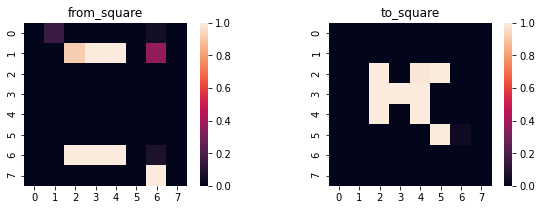

In [175]:
import seaborn as sns

fig,axes = plt.subplots(ncols=2,squeeze = True,figsize = (10,3))
sns.heatmap(pred[0,0].reshape(8,8),square = True,ax = axes[0])
sns.heatmap(pred[0,1].reshape(8,8),square = True,ax = axes[1])

axes[0].set_title("from_square")
axes[1].set_title("to_square")

plt.show()